# SiebenApp Rendering v3.0

A short SiebenApp rendering history.

* v1.0: use `GraphViz` to render all nodes and draw a picture.
* v2.0: rewrite rendering from scratch using Sugiyama method.
* v2.5: add few custom hacks to Sugiyama method (e.g., enforce width limit).
* v3.0: this approach.


## Use raw data structures

In [1]:
# Some example graph
edges = {
    1: [8, 10, 12, 13],
    2: [5],
    3: [6],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [11],
    11: [3],
    12: [2, 4, 14],
    13: [7, 9],
    14: [],
}

In [2]:
# Rendering defaults
WIDTH = 3

Let's visualize a graph.

In [3]:
import matplotlib.pyplot as plt

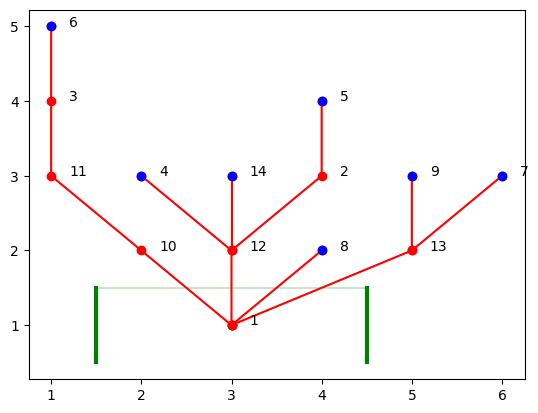

In [4]:
# Tree structure and not-switchable nodes
plt.plot([3, 2, 1, 1, 1], [1, 2, 3, 4, 5], 'ro-')
plt.plot([3, 3, 2], [1, 2, 3], 'ro-')
plt.plot([3, 3], [2, 3], 'ro-')
plt.plot([3, 4, 4], [2, 3, 4], 'ro-')
plt.plot([3, 4], [1, 2], 'ro-')
plt.plot([3, 5, 5], [1, 2, 3], 'ro-')
plt.plot([5, 6], [2, 3], 'ro-')
# Mark switchable nodes
plt.plot([1, 2, 3, 4, 4, 5, 6], [5, 3, 3, 4, 2, 3, 3], 'bo')
# Draw labels
plt.text(3.2, 1, "1"); plt.text(4.2, 3, "2"); plt.text(1.2, 4, "3")
plt.text(2.2, 3, "4"); plt.text(4.2, 4, "5"); plt.text(1.2, 5, "6")
plt.text(6.2, 3, "7"); plt.text(4.2, 2, "8"); plt.text(5.2, 3, "9")
plt.text(2.2, 2, "10"); plt.text(1.2, 3, "11"); plt.text(3.2, 2, "12")
plt.text(5.2, 2, "13"); plt.text(3.2, 3, "14")
# Draw "tube" with width 3
plt.plot([1.5, 1.5], [0.5, 1.5], 'g-', linewidth=3.0)
plt.plot([4.5, 4.5], [0.5, 1.5], 'g-', linewidth=3.0)
plt.plot([1.5, 4.5], [1.5, 1.5], 'g-', linewidth=0.3)
plt.show()

First, we want to place all nodes (goals) onto layers with maximum width of `WIDTH`. We start from `root` and move on edges.

In [5]:
from typing import Dict, List

def tube(edges: Dict[int, List[int]], roots: List[int], layers: List[List[int]]):
    new_layer: List[int] = roots[:WIDTH]
    new_roots: List[int] = roots[len(new_layer):] + [e for n in new_layer for e in edges[n]]
    return new_roots, layers + [new_layer]

In [6]:
r = [1]
l = []

while r:
    r, l = tube(edges, r, l)

l

[[1], [8, 10, 12], [13, 11, 2], [4, 14, 7], [9, 3, 5], [6]]

Let's visualise it as is.

In [7]:
def draw(edges: Dict[int, List[int]], layers: List[List[int]]) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for i, layer in enumerate(layers):
        for j, n in enumerate(layer):
            xpos[n] = j + 1
            ypos[n] = i + 1
    for goal_id, gs in edges.items():
        for g1 in gs:
            plt.plot([xpos[goal_id], xpos[g1]], [ypos[goal_id], ypos[g1]], 'ro-')
        plt.text(xpos[goal_id] + 0.1, ypos[goal_id], str(goal_id))
    switchables = [g for g, gs in edges.items() if not gs]
    xs = [xpos[g] for g in switchables]
    ys = [ypos[g] for g in switchables]
    plt.plot(xs, ys, 'bo')
    plt.draw()

Initial graph version:

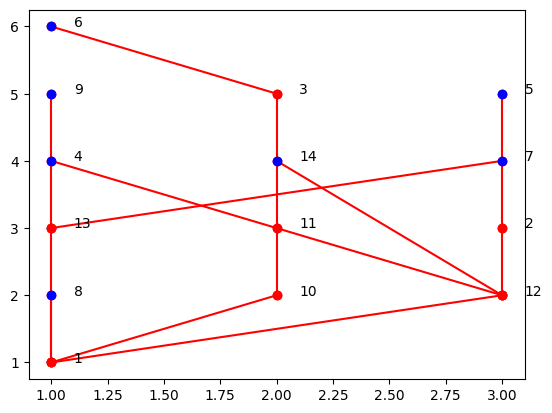

In [8]:
draw(edges, l)

Next step is to find the best possible node placement for each layer. We calculate the 'force' that 'tows' each node to the left or to the right. And then find a node combination with a minimal total force. This step is **NP-full**.

In [9]:
# [1, x, x] -> {8: 0, 10: 1, 12: 2, 13: 0} -> [0, 1, 2, 0] -> (abs(0) + abs(1) + abs(2) + abs(0), abs(0 + 1 + 2 + 0)) -> (3, 3)
# [x, 1, x] -> {8: -1, 10: 0, 12: 1, 13: -1} -> [-1, 0, 1, -1] -> (abs(-1) + abs(0) + abs(1) + abs(-1), abs(-1 + 0 + 1 -1)) -> (3, 1)
# [x, x, 1] -> {8: -2, 10: -1, 12: 0, 13: -2} -> [-2, -1, 0, -2] -> (abs(-2) + abs(-1) + abs(0) + abs(-2), abs(-2 - 1 + 0 - 2)) -> (5, 5)
#
# (3, 1) < (3, 3) < (5, 5)
# [x, 1, x] is the best position

## Use existing SiebenApp structures

In SiebenApp, we use the following structures in rendering algorithm:

In [52]:
from dataclasses import dataclass, field, replace
from enum import IntEnum
from typing import Any, Union, Optional

In [13]:
# One of two supported edge types
class EdgeType(IntEnum):
    BLOCKER = 1
    PARENT = 2

# Edge between two goals (wow, it doesn't use GoalId, right?)
@dataclass(frozen=True)
class Edge:
    source: int
    target: int
    type: EdgeType

# For leegacy reasons, goal id may be either integer (real or pseudo goal) or string (pseudo goal only)
GoalId = Union[str, int]

# Single row of "render result" (well, actually, it's a single goal)
@dataclass(frozen=True)
class RenderRow:
    """Strongly typed rendered representation of a single goal."""

    goal_id: GoalId
    raw_id: int
    name: str
    is_open: bool
    is_switchable: bool
    edges: list[tuple[GoalId, EdgeType]]
    attrs: dict[str, str] = field(default_factory=lambda: {})

# A whole result of "rendering" (also suitable for result returned by a single request to goal tree)
@dataclass
class RenderResult:
    rows: list[RenderRow]
    edge_opts: dict[str, tuple[int, int, int]]
    select: tuple[GoalId, GoalId]
    node_opts: dict[GoalId, Any]
    roots: set[GoalId]
    index: dict[GoalId, int]

    def __init__(
        self,
        rows: list[RenderRow],
        edge_opts: Optional[dict[str, tuple[int, int, int]]] = None,
        select: Optional[tuple[GoalId, GoalId]] = None,
        node_opts: Optional[dict[GoalId, Any]] = None,
        roots: Optional[set[GoalId]] = None,
    ):
        self.rows = rows
        self.edge_opts = edge_opts or {}
        self.select = select or (0, 0)
        self.node_opts = node_opts or {}
        self.roots = roots or set()
        self.index = {row.goal_id: i for i, row in enumerate(rows)}

    def goals(self):
        return [
            (goal_id, attrs)
            for goal_id, attrs in self.node_opts.items()
            if isinstance(goal_id, int)
        ]

    def by_id(self, goal_id: GoalId) -> RenderRow:
        assert goal_id in self.index
        return self.rows[self.index[goal_id]]


Our goal is to recreate algorithm above using these structures, not just raw dicts.

In [24]:
sample_result = RenderResult(
    [
        RenderRow(k, k, f"Goal {k}", True, not es,
                  [(e, EdgeType.PARENT) for e in es], {})
        for k, es in edges.items()
    ],
    node_opts={k: {} for k in edges},
    select=(1, 1),
    roots={1},
)

In [25]:
sample_result

RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='Goal 1', is_open=True, is_switchable=False, edges=[(8, <EdgeType.PARENT: 2>), (10, <EdgeType.PARENT: 2>), (12, <EdgeType.PARENT: 2>), (13, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='Goal 2', is_open=True, is_switchable=False, edges=[(5, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='Goal 3', is_open=True, is_switchable=False, edges=[(6, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='Goal 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='Goal 5', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=6, raw_id=6, name='Goal 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='Goal 7', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=8, raw_id=8, name='Goal 8', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(g

In [28]:
from random import randint

In [85]:
def draw1(rr: RenderResult) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for goal_id, attrs in rr.goals():
        row, col = attrs.get("row", None), attrs.get("col", None)
        # print(goal_id, row, col)
        xpos[goal_id] = col if col is not None else randint(0, 10)
        ypos[goal_id] = row if row is not None else randint(0, 10) 
    # print(xpos)
    # print(ypos)
    for row in rr.rows:
        row_id = row.goal_id
        for edge in row.edges:
            e = edge[0]
            plt.plot([xpos[row_id], xpos[e]], [ypos[row_id], ypos[e]], 'ro-')
        plt.text(xpos[row_id] + 0.1, ypos[row_id], row.name)
    tops = [row.goal_id for row in rr.rows if row.is_switchable]
    plt.plot([xpos[t] for t in tops], [ypos[t] for t in tops], 'bo')
    plt.draw()

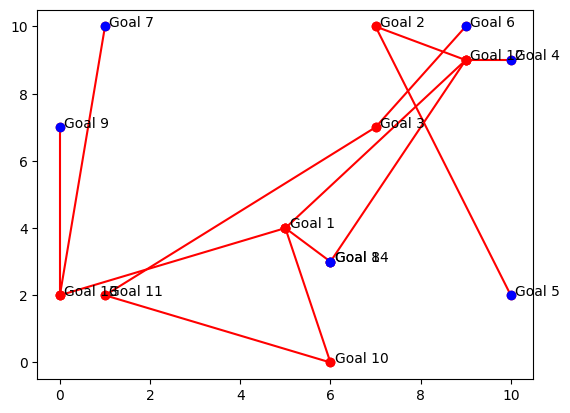

In [88]:
draw1(sample_result)

In [78]:
def add_if_not(m: Dict, m1: Dict) -> Dict:
    nm = dict(m)
    for k, v in m1.items():
        if nm.get(k, None) is None:
            nm[k] = v
    return nm

def tube1(rr: RenderResult, roots: List[int], layers: List[List[int]]):
    new_layer: List[int] = roots[:WIDTH]
    new_roots: List[int] = roots[len(new_layer):] + [e[0] for gid in new_layer for e in rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in rr.node_opts.items()
    }
    
    return RenderResult(rr.rows, node_opts=new_opts, select=rr.select, roots=rr.roots), new_roots, layers + [new_layer]

In [79]:
rr1, roots1, layers1 = tube1(sample_result, list(sample_result.roots), [])
rr1, roots1, layers1

(RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='Goal 1', is_open=True, is_switchable=False, edges=[(8, <EdgeType.PARENT: 2>), (10, <EdgeType.PARENT: 2>), (12, <EdgeType.PARENT: 2>), (13, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='Goal 2', is_open=True, is_switchable=False, edges=[(5, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='Goal 3', is_open=True, is_switchable=False, edges=[(6, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='Goal 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='Goal 5', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=6, raw_id=6, name='Goal 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='Goal 7', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=8, raw_id=8, name='Goal 8', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(

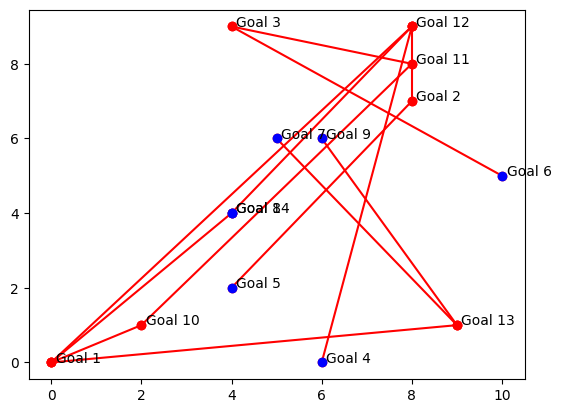

In [89]:
draw1(rr1)

In [90]:
rr2, roots2, layers2 = tube1(rr1, roots1, layers1)
rr2, roots2, layers2

(RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='Goal 1', is_open=True, is_switchable=False, edges=[(8, <EdgeType.PARENT: 2>), (10, <EdgeType.PARENT: 2>), (12, <EdgeType.PARENT: 2>), (13, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='Goal 2', is_open=True, is_switchable=False, edges=[(5, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='Goal 3', is_open=True, is_switchable=False, edges=[(6, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='Goal 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='Goal 5', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=6, raw_id=6, name='Goal 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='Goal 7', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=8, raw_id=8, name='Goal 8', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(

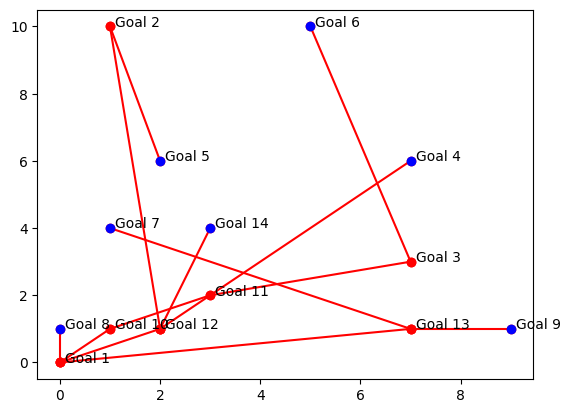

In [91]:
draw1(rr2)

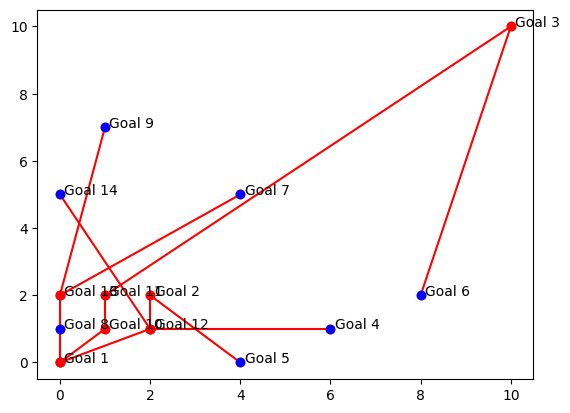

In [93]:
rr3, roots3, layers3 = tube1(rr2, roots2, layers2)
draw1(rr3)

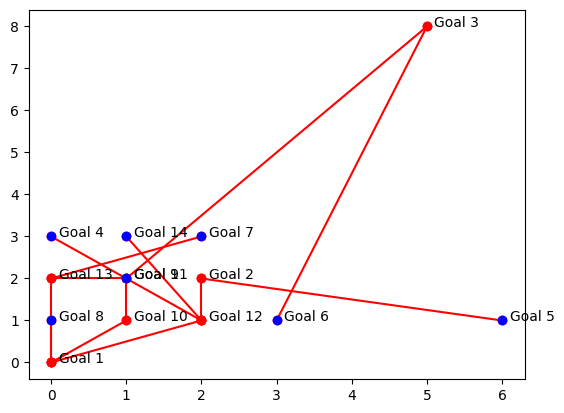

In [94]:
rr4, roots4, layers4 = tube1(rr3, roots3, layers3)
draw1(rr4)

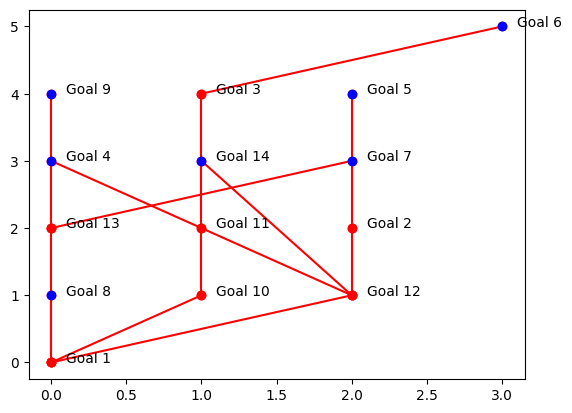

In [95]:
rr5, roots5, layers5 = tube1(rr4, roots4, layers4)
draw1(rr5)

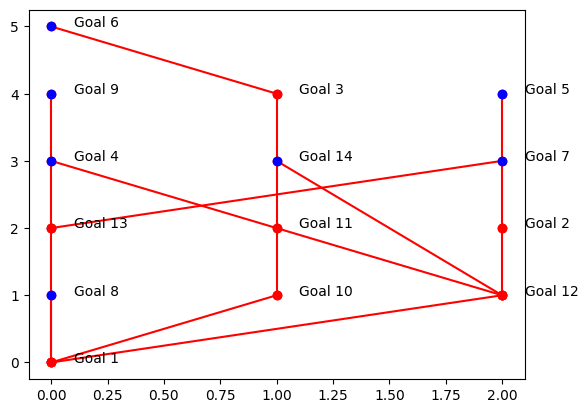

In [96]:
rr6, roots6, layers6 = tube1(rr5, roots5, layers5)
draw1(rr6)

In [97]:
roots6, layers6

([], [[1], [8, 10, 12], [13, 11, 2], [4, 14, 7], [9, 3, 5], [6]])

Variable `roots6` is empty, so we've finished.